<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/QRS_detection/QRS_detection_CNN%2BLSTM_70sample_MIT_DB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/
#or
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org' '/content/physionet.org'

In [1]:
!pip install wfdb numpy scipy matplotlib scikit-learn tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 930.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


# Gloabal variables

In [3]:
G_window_size = 70
G_overlap = 65
G_fs = 360
G_q_offset = 33

# 1- Signal traitement functions

## 1-1- Preprocess the Signal

### A. Filtering

In [4]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def bandpass_filter(data, fs, lowcut=0.5, highcut=40.0, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered = signal.filtfilt(b, a, data)
    return filtered

def differentiate_signal(data, fs):
    # Differentiate the signal using a first-order difference
    differentiated = np.diff(data, prepend=data[0])
    return differentiated

def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed


### B. Normalization

In [5]:
def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)


## 1-2- Segment the Signal for QRS Detection

In [6]:
import numpy as np

def segment_signal(signal, window_size=G_window_size, overlap=G_overlap ):
    """
    Segment the signal into fixed-length windows with a specified overlap.

    Args:
        signal (np.array): The input signal.
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        tuple: (Array of segmented windows, Array of segment start indices)
    """
    segments = []
    segment_indices = []

    step = window_size - overlap  # Step size for sliding window
    for start in range(0, len(signal) - window_size + 1, step):
        end = start + window_size
        segments.append(signal[start:end])
        segment_indices.append(start)  # Store segment start position

    return np.array(segments), np.array(segment_indices)




## 1-3- Labeling and Combining the Data

In [7]:
import numpy as np

def label_segments(normalized_signal,segments, segment_starts, qrs_indices, q_offset=G_q_offset, window_size=G_window_size, overlap=G_overlap):
    """
    Label each segment as QRS (1) or non-QRS (0), ensuring an equal number of 0 and 1 labels.

    Args:
        segments (np.array): Array of segmented windows.
        segment_starts (np.array): Start indices of segments.
        qrs_indices (list): List of QRS indices (in samples).
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        np.array: Array of labels (1 for QRS, 0 for non-QRS).
    """
    labels = np.zeros(len(segments), dtype=int)

    # Label QRS segments
    for i, segment_start in enumerate(segment_starts):
        segment_end = segment_start + window_size

        # Check if any QRS index falls within this segment
        for r_peak in qrs_indices:
            q_start = r_peak - q_offset  # Approximate Q start
            s_end = r_peak + q_offset    # Approximate S end

            # Ensure q_start and s_end are within bounds
            q_start = max(0, q_start)
            s_end = min(len(normalized_signal) - 1, s_end)

            if segment_start <= q_start and segment_end >= s_end:
                labels[i] = 1
                break

    # Balance the dataset by randomly sampling non-QRS segments
    qrs_count = np.sum(labels == 1)  # Number of QRS segments
    non_qrs_indices = np.where(labels == 0)[0]  # Indices of non-QRS segments

    # Randomly sample non-QRS segments to match the number of QRS segments
    if len(non_qrs_indices) > qrs_count:
        sampled_non_qrs_indices = np.random.choice(non_qrs_indices, size=qrs_count, replace=False)
        labels[sampled_non_qrs_indices] = 0  # Ensure sampled non-QRS segments are labeled as 0
    else:
        print("Warning: Not enough non-QRS segments to balance the dataset.")

    return labels




In [8]:
import numpy as np
import matplotlib.pyplot as plt
def display_segment(normalized_signal,segment_labels,segment_starts,z_start,z_end):
  # Define sampling rate

  # Define zoom window in **seconds**
  zoom_start_sec = z_start   # Start time in seconds
  zoom_end_sec = z_end     # End time in seconds

  # Convert zoom window from seconds to samples
  zoom_start = zoom_start_sec * G_fs  # Convert to sample index
  zoom_end = zoom_end_sec * G_fs      # Convert to sample index

  # Function to filter windows within the zoom range (in sample indices)
  def filter_windows_in_zoom(windows, zoom_start, zoom_end):
      """Filter windows that fall within the zoom range in samples."""
      return [(start, end) for start, end in windows if start < zoom_end and end > zoom_start]

  # Identify segment start and end in samples
  positive_windows = [(segment_starts[i], segment_starts[i] + G_window_size) for i in range(len(segment_labels)) if segment_labels[i] == 1]
  negative_windows = [(segment_starts[i], segment_starts[i] + G_window_size) for i in range(len(segment_labels)) if segment_labels[i] == 0]
  print("Number of positive (QRS) segments:", len(positive_windows))
  print("Number of negative (non-QRS) segments:", len(negative_windows))
  # Filter positive and negative windows within the zoom range
  positive_windows_zoom = filter_windows_in_zoom(positive_windows, zoom_start, zoom_end)
  negative_windows_zoom = filter_windows_in_zoom(negative_windows, zoom_start, zoom_end)

  # Create time axis in **seconds**
  time_axis = np.arange(len(normalized_signal)) / G_fs  # Convert samples to seconds

  # Plot 1: Positive (QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

  # Highlight positive (QRS) windows in red (only within the zoom range)
  for start, end in positive_windows_zoom:
      plt.axvspan(start / G_fs, end / G_fs, color="red", alpha=0.3, label="QRS Segment" if start == positive_windows_zoom[0][0] else "")

  plt.title(f"Positive (QRS) Segments (Window Size: {G_window_size} samples, Overlap: {G_overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()

  # Plot 2: Negative (Non-QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

  # Highlight negative (non-QRS) windows in yellow (only within the zoom range)
  for start, end in negative_windows_zoom:
      plt.axvspan(start / G_fs, end / G_fs, color="yellow", alpha=0.3, label="Non-QRS Segment" if start == negative_windows_zoom[0][0] else "")
      #plt.vlines(start / G_fs, ymin=np.min(normalized_signal), ymax=np.max(normalized_signal), color="green", linestyle="dashed", alpha=0.6, label="Segment Start")

  plt.title(f"Negative (Non-QRS) Segments (Window Size: {G_window_size} samples, Overlap: {G_overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()


## 1-4. traitement sigments

In [9]:
def remove_consecutive_ones(segment_labels, segmented_signal, segment_starts):
    filtered_labels = []
    filtered_signal = []
    filtered_starts = []

    i = 0


    while i < len(segment_labels)-1:
        if segment_labels[i] == 1:
            # Find the range of consecutive ones
            start = i
            while i + 1 < len(segment_labels) and segment_labels[i + 1] == 1:
                i += 1
            end = i

            # Compute the middle index of the block
            mid = (start + end) // 2

            # Keep only the middle one
            filtered_labels.append(segment_labels[mid])
            filtered_signal.append(segmented_signal[mid])
            filtered_starts.append(segment_starts[mid])

        else:
            # Keep zeros as they are
            filtered_labels.append(segment_labels[i])
            filtered_signal.append(segmented_signal[i])
            filtered_starts.append(segment_starts[i])

        i += 1  # Move to the next segment

    return filtered_labels, filtered_signal, filtered_starts

In [10]:
def remove_touching_negatives(segment_labels, segmented_signal, segment_starts):
    new_labels = segment_labels[:]  # Copy original lists
    new_signal = segmented_signal[:]
    new_starts = segment_starts[:]

    step = G_window_size - G_overlap  # Compute the step size
    num_windows = max(1, round(G_window_size / step))-1 # Number of windows to remove (ensure at least 1)
    to_remove = set()  # Indices to remove

    for i, label in enumerate(segment_labels):
        if label == 1:  # If it's a positive window
            # Mark 4 windows before and after for removal
            for j in range(max(0, i - num_windows), min(len(segment_labels), i + num_windows + 1)):
                if segment_labels[j] == 0:  # Only remove negatives
                    to_remove.add(j)

    # Remove marked indices
    new_labels = [label for i, label in enumerate(segment_labels) if i not in to_remove]
    new_signal = [signal for i, signal in enumerate(segmented_signal) if i not in to_remove]
    new_starts = [start for i, start in enumerate(segment_starts) if i not in to_remove]

    return new_labels, new_signal, new_starts



In [11]:
import random

def balance_classes(segment_labels, segmented_signal, segment_starts):
    # Count positive and negative instances
    num_positives = sum(1 for label in segment_labels if label == 1)
    num_negatives = sum(1 for label in segment_labels if label == 0)

    # If negatives are already balanced, return as is
    if num_negatives <= num_positives:
        return segment_labels, segmented_signal, segment_starts

    # Get indices of negative samples
    negative_indices = [i for i, label in enumerate(segment_labels) if label == 0]

    # Randomly select indices to remove
    num_to_remove = num_negatives - num_positives
    indices_to_remove = set(random.sample(negative_indices, num_to_remove))

    # Remove selected negatives while keeping lists synchronized
    new_labels = [label for i, label in enumerate(segment_labels) if i not in indices_to_remove]
    new_signal = [signal for i, signal in enumerate(segmented_signal) if i not in indices_to_remove]
    new_starts = [start for i, start in enumerate(segment_starts) if i not in indices_to_remove]

    return new_labels, new_signal, new_starts



# 2- preparing signals

In [13]:
import wfdb
import numpy as np
from scipy.signal import resample

# Replace '100' with the record number you want to load
record_dir = '/content/physionet.org/files/mitdb/1.0.0/'
record_names = wfdb.get_record_list('mitdb')


all_segments = []
all_segment_labels = []
all_segment_starts = []

for record_name in record_names:
    print(f"Processing record: {record_name}")
    # load signal
    record = wfdb.rdrecord(record_dir+record_name)
    annotation = wfdb.rdann(record_dir+record_name, 'atr')
    ecg_signal = record.p_signal[:, 0]
    G_fs = record.fs


    # Example usage
    time_axis = np.arange(0, len(ecg_signal)) / G_fs  # Time axis in seconds

    # Apply bandpass filter and smooth the signal
    filtered_signal = bandpass_filter(ecg_signal, 1000)
    smoothed_signal = smooth_signal(filtered_signal, window_size=5)


    # Normalize the smoothed signal
    normalized_signal = normalize_signal(smoothed_signal)


    # Apply segmentation
    segmented_signal, segment_starts = segment_signal(normalized_signal, window_size=G_window_size, overlap=G_overlap)


    # Filter the annotation symbols to include only typical QRS types (adjust as needed)
    qrs_symbols = ['N', 'L', 'R', 'V', 'A']  # Common QRS annotation symbols
    qrs_indices = [s for s, sym in zip(annotation.sample, annotation.symbol) if sym in qrs_symbols]

    # Label the segments using actual segment start positions
    segment_labels = label_segments( normalized_signal, segmented_signal, segment_starts, qrs_indices, q_offset=G_q_offset, window_size=G_window_size, overlap=G_overlap)


    # Traitement
    segment_labels, segmented_signal, segment_starts = remove_consecutive_ones(segment_labels, segmented_signal, segment_starts)
    segment_labels, segmented_signal, segment_starts = remove_touching_negatives(segment_labels, segmented_signal, segment_starts)
    segment_labels, segmented_signal, segment_starts = balance_classes(segment_labels, segmented_signal, segment_starts)
    print(f"{record_name} positive: {np.sum(np.array(segment_labels) == 1)}, negative: {np.sum(np.array(segment_labels) == 0)}")

    # save segments
    np.savez("/content/drive/MyDrive/Final project/QRS detection/segments/"+record_name+" segment 70s 65o 33q.npz",
             segments=np.array(segmented_signal, dtype=object),
             labels=np.array(segment_labels),
             starts=np.array(segment_starts))

    # Store all data
    all_segments.extend(segmented_signal)
    all_segment_labels.extend(segment_labels)
    all_segment_starts.extend(segment_starts)

print(f"Total segments collected: {len(all_segments)}")


Processing record: 100
100 positive: 2272, negative: 2272
Processing record: 101
101 positive: 1863, negative: 1863
Processing record: 102
102 positive: 103, negative: 103
Processing record: 103
103 positive: 2084, negative: 2084
Processing record: 104
104 positive: 165, negative: 165
Processing record: 105
105 positive: 2567, negative: 2567
Processing record: 106
106 positive: 2027, negative: 2027
Processing record: 107
107 positive: 59, negative: 59
Processing record: 108
108 positive: 1760, negative: 1760
Processing record: 109
109 positive: 2530, negative: 2530
Processing record: 111
111 positive: 2124, negative: 2124
Processing record: 112
112 positive: 2539, negative: 2539
Processing record: 113
113 positive: 1788, negative: 1788
Processing record: 114
114 positive: 1873, negative: 1873
Processing record: 115
115 positive: 1953, negative: 1953
Processing record: 116
116 positive: 2412, negative: 2412
Processing record: 117
117 positive: 1535, negative: 1535
Processing record: 118

In [14]:
import numpy as np

# save segments

np.savez("mitbid segments 70s 65o 33q.npz",
         segments=np.array(all_segments, dtype=object),
         labels=np.array(all_segment_labels),
         starts=np.array(all_segment_starts))

!cp '/content/mitbid segments 70s 65o 33q.npz' '/content/drive/MyDrive/Final project/QRS detection/segments/mitbid segments 70s 65o 33q.npz'

In [3]:
#import numpy as np
## load segments
#data = np.load("/content/drive/MyDrive/Final project/QRS detection/mitbid segments 70s 65o 33q.npz", allow_pickle=True)
#
## Extract lists
#all_segments = data["segments"].tolist()
#all_segment_labels = data["labels"].tolist()
#all_segment_starts = data["starts"].tolist()
#
#print("Data loaded successfully!")


Data loaded successfully!


# 3-data Traitement

In [15]:
segment_labels = np.array(all_segment_labels)
segmented_signal = np.array(all_segments)
segment_starts = np.array(all_segment_starts)

## A. Shuffle and Reshape Data

In [16]:
from sklearn.utils import shuffle
import numpy as np

# Shuffle the data
all_segments, all_labels = shuffle(segmented_signal, segment_labels, random_state=42)

# Reshape to (num_samples, window_length, 1)
all_segments = all_segments.reshape(all_segments.shape[0], all_segments.shape[1], 1)
print("Reshaped data for CNN+LSTM:", all_segments.shape)

# Ensure all_labels is a 1D array
all_labels = np.array(all_labels).flatten()  # Convert to 1D array if it's not already
print("Shape of all_labels:", all_labels.shape)

# Separate positive and negative segments
positive_segments = all_segments[all_labels == 1]  # Index using the 1D boolean array
negative_segments = all_segments[all_labels == 0]

# Undersample the majority class (negative segments)
num_positive = len(positive_segments)
negative_segments_balanced = negative_segments[:num_positive]  # Take the same number as positive segments

# Combine balanced positive and negative segments
balanced_segments = np.concatenate([positive_segments, negative_segments_balanced])
balanced_labels = np.concatenate([np.ones(num_positive), np.zeros(num_positive)])  # Labels: 1 for QRS, 0 for non-QRS

# Shuffle the balanced dataset
balanced_segments, balanced_labels = shuffle(balanced_segments, balanced_labels, random_state=42)

# Reshape to (num_samples, window_length, 1)
balanced_segments = balanced_segments.reshape(balanced_segments.shape[0], balanced_segments.shape[1], 1)
print("Balanced data shape:", balanced_segments.shape)

Reshaped data for CNN+LSTM: (200118, 70, 1)
Shape of all_labels: (200118,)
Balanced data shape: (200118, 70, 1)


## B. Split

In [17]:
from sklearn.model_selection import train_test_split

# Split into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_segments, balanced_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (120070, 70, 1) (120070,)
Validation: (40024, 70, 1) (40024,)
Test: (40024, 70, 1) (40024,)


In [18]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train: (120070, 70, 1)
Shape of y_train: (120070,)


In [19]:
# Reshape y_train, y_val, and y_test to match the model's output shape
y_train = y_train.reshape(-1, 1, 1)  # Shape: [num_samples, 1, 1]
y_val = y_val.reshape(-1, 1, 1)      # Shape: [num_samples, 1, 1]
y_test = y_test.reshape(-1, 1, 1)    # Shape: [num_samples, 1, 1]

# Verify shapes
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (120070, 70, 1) (120070, 1, 1)
Validation: (40024, 70, 1) (40024, 1, 1)
Test: (40024, 70, 1) (40024, 1, 1)


In [20]:
import numpy as np

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [21]:
print("NaN in X_train:", np.isnan(X_train).any())
print("Inf in X_train:", np.isinf(X_train).any())
print("NaN in y_train:", np.isnan(y_train).any())
print("Inf in y_train:", np.isinf(y_train).any())

NaN in X_train: False
Inf in X_train: False
NaN in y_train: False
Inf in y_train: False


# 4- Build the Hybrid CNN + LSTM Model

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Flatten, Reshape,
    Bidirectional, LSTM, Dense, Dropout, TimeDistributed
)
# Parameters
window_length = G_window_size  # Fixed window length (e.g., 250 samples)
input_shape = (window_length, 1)  # Input shape: (batch_size, 250, 1)

# Define the CNN + LSTM model architecture
model = Sequential()

# --- CNN layers ---
# Input shape: (250, 1)
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Second Conv1D layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Third Conv1D layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# --- Flatten and reshape for LSTM ---
model.add(Flatten())

# Automatically calculate the flattened shape
flattened_shape = model.output_shape[1]  # Get the shape after Flatten
print(f"Flattened shape: {flattened_shape}")

# Reshape to (timesteps, features) for LSTM
model.add(Reshape((1, flattened_shape)))  # Reshape dynamically

model.add(Bidirectional(LSTM(units=100, return_sequences=False)))  # No need for return_sequences=True

# --- Fully Connected Layers ---
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))

# --- Output Layer ---
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()# Binary classification (QRS vs. non-QRS)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Flattened shape: 768


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 66, 32)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 33, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 33, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 31, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 15, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 13, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 6, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 1, 768)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 200)                 │         695,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 737,301 (2.81 MB)

 Trainable params: 736,853 (2.81 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 66, 32)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 33, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 33, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 31, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 15, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 13, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 6, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 1, 768)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 200)                 │         695,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 737,301 (2.81 MB)

 Trainable params: 736,853 (2.81 MB)

 Non-trainable params: 448 (1.75 KB)

# 5- Train the Model

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train Model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32,
          callbacks=[early_stopping, lr_scheduler])



Epoch 1/50
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 122s 30ms/step - accuracy: 0.9902 - loss: 0.0341 - val_accuracy: 0.9934 - val_loss: 0.0222 - learning_rate: 0.0010
Epoch 2/50
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 114s 30ms/step - accuracy: 0.9956 - loss: 0.0175 - val_accuracy: 0.9958 - val_loss: 0.0167 - learning_rate: 0.0010
Epoch 3/50
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 110s 29ms/step - accuracy: 0.9957 - loss: 0.0168 - val_accuracy: 0.9969 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 4/50
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 148s 31ms/step - accuracy: 0.9966 - loss: 0.0139 - val_accuracy: 0.9967 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 5/50
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 136s 29ms/step - accuracy: 0.9966 - loss: 0.0140 - val_accuracy: 0.9967 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 6/50
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 116s 31ms/step - accuracy: 0.9969 - loss: 0.0133 - val_accuracy: 0.9971 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 7/50
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 137s 30ms/step -

# 6- Evaluate and Test the Model

In [26]:
from sklearn.metrics import classification_report

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
# Flatten y_test and y_pred to 1D arrays
y_test_flat = y_test.reshape(-1)  # Shape: (num_samples,)
y_pred_flat = y_pred.reshape(-1)  # Shape: (num_samples,)

# Print classification report
print(classification_report(y_test_flat, y_pred_flat))

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19994
         1.0       1.00      1.00      1.00     20030

    accuracy                           1.00     40024
   macro avg       1.00      1.00      1.00     40024
weighted avg       1.00      1.00      1.00     40024



In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.9980
Recall: 0.9981
F1-Score: 0.9980


In [28]:
from keras.saving import save_model

# Save the trained model
save_model(model,"/content/drive/MyDrive/Final project/QRS detection/qrs_cnn_lstm_model_70sample_MITDB.keras")
model.save("/content/drive/MyDrive/Final project/QRS detection/qrs_cnn_lstm_model_70sample_MITDB.h5")


# 7- Model Test

In [ ]:
from tensorflow.keras.models import load_model
# Load the model later for inference
#model = load_model("/content/drive/MyDrive/Final project/QRS detection/qrs_cnn_lstm_model_70sample_MITDB.h5")

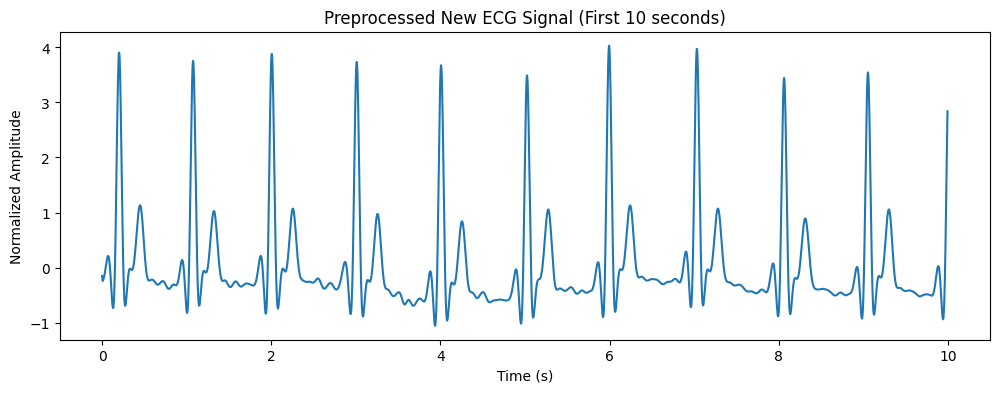

In [40]:
import wfdb
record_dir='/content/test/'
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
new_record_name='e0103'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
new_annotation = wfdb.rdann(new_record_name, 'atr')
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

# Apply bandpass filter
new_filtered_signal = bandpass_filter(new_ecg_signal, 1000)
# Optionally smooth the signal
new_smoothed_signal = smooth_signal(new_filtered_signal, window_size=5)
new_normalized_signal = normalize_signal(new_smoothed_signal)


# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()



In [41]:



# Segment the normalized signal
new_segments,new_start_segments = segment_signal(new_normalized_signal, window_size=G_window_size, overlap=G_overlap)

print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



Extracted 359987 segments with window size 70 and 65 samples overlap.


In [42]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
new_segments_reshaped = new_segments.reshape(new_segments.shape[0], new_segments.shape[1], 1)

# Print the shape
print("Shape of input segments for model:", new_segments_reshaped.shape)


Shape of input segments for model: (359987, 70, 1)


In [43]:
# Predict using the trained model
predictions = model.predict(new_segments_reshaped)

# Convert predictions to binary labels (threshold at 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Print results
print("Predicted QRS presence for each segment:", predicted_labels.flatten())


11250/11250 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step
Predicted QRS presence for each segment: [0 0 0 ... 0 0 0]


## display results

Number of positive (QRS) segments: 26458
Number of negative (non-QRS) segments: 333529


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


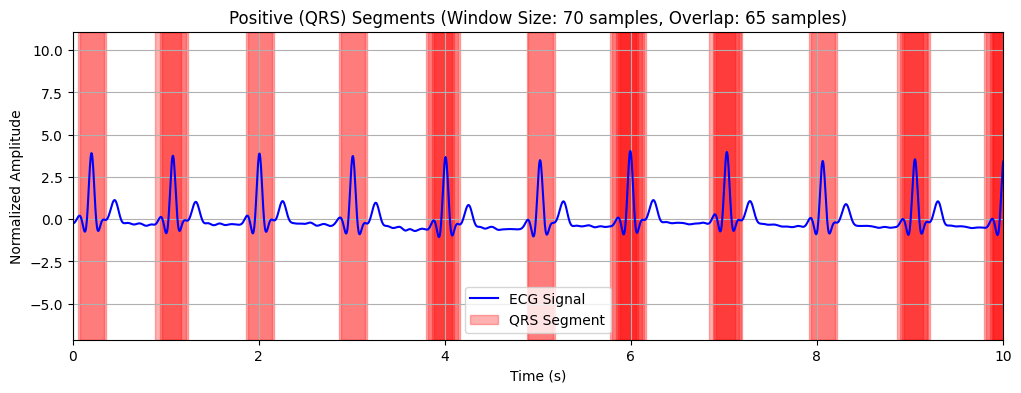

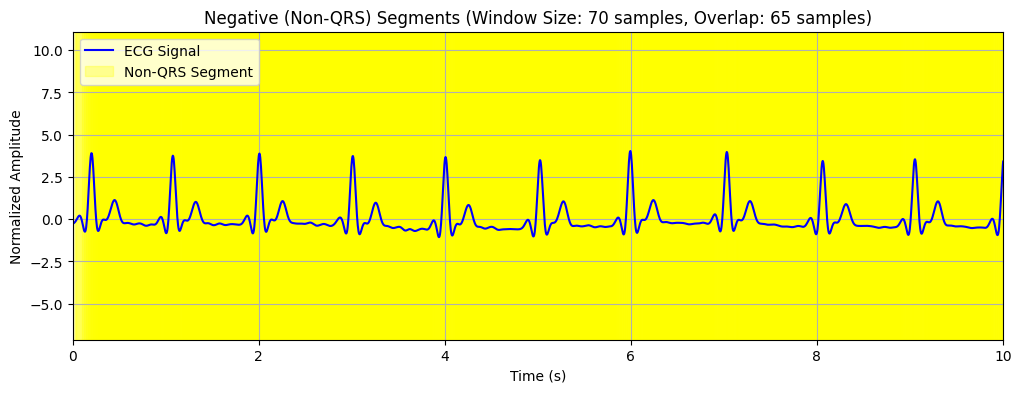

In [44]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of positive (QRS) segments: 26458
Number of negative (non-QRS) segments: 333529


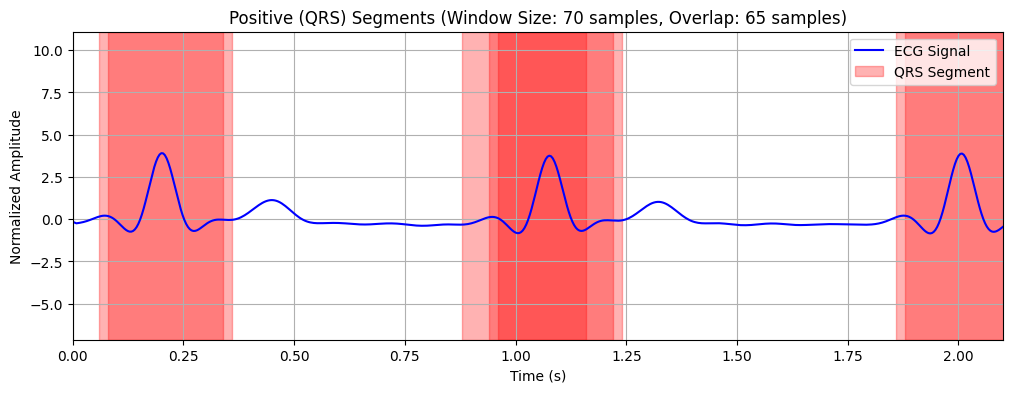

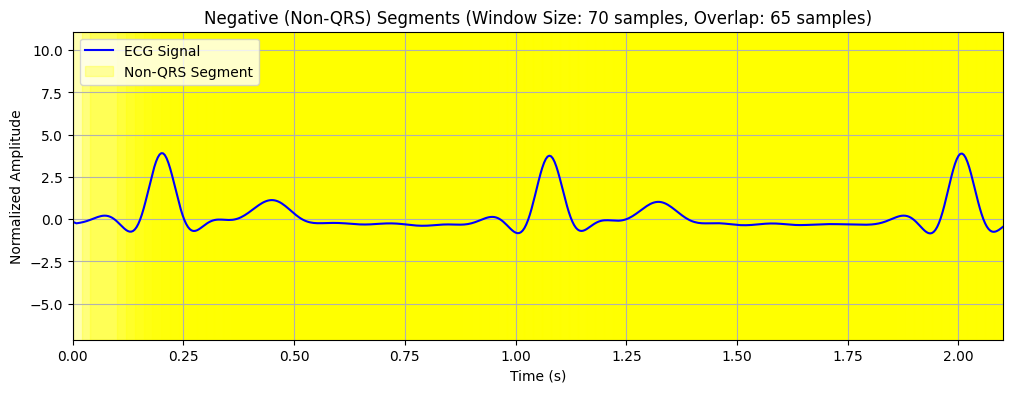

In [45]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

## Improvement

In [46]:
#print(len(real_labels))
#real_segments,real_start_segments=new_segments, new_start_segments
#real_labels, real_segments, real_start_segments = remove_consecutive_ones( real_labels, real_segments, real_start_segments)
#real_labels, real_segments, real_start_segments = remove_touching_negatives( real_labels, real_segments, real_start_segments)
#print(len(real_labels))

In [47]:

predicted_labels, new_segments, new_start_segments = remove_consecutive_ones( predicted_labels, new_segments, new_start_segments)
predicted_labels, new_segments, new_start_segments = remove_touching_negatives( predicted_labels, new_segments, new_start_segments)
predicted_labels=np.array(predicted_labels)

#eval_new_signal(real_labels=real_labels,predicted_labels=predicted_labels)

In [48]:
print(len(predicted_labels))
#print(len(real_labels))

125122


Number of positive (QRS) segments: 14740
Number of negative (non-QRS) segments: 110382


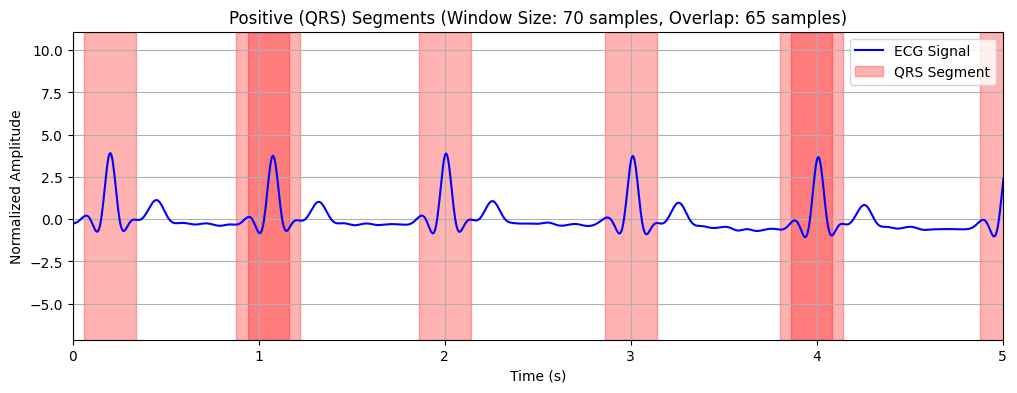

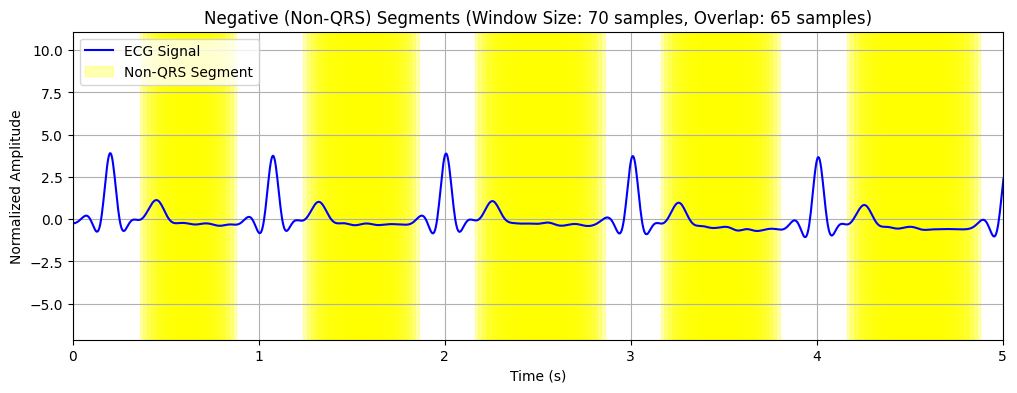

In [51]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,5)

## Evaluate detections

In [ ]:
# Filter the annotation symbols to include only typical QRS types (adjust as needed)
new_qrs_symbols = ['N', 'L', 'R', 'V', 'A']  # Common QRS annotation symbols
new_qrs_indices = [s for s, sym in zip(new_annotation.sample, new_annotation.symbol) if sym in new_qrs_symbols]

# Label the segments using actual segment start positions
# Correct the function call to pass arguments in the correct order
real_labels = label_segments(new_normalized_signal, new_segments, new_start_segments, new_qrs_indices, q_offset=G_q_offset, window_size=G_window_size, overlap=G_overlap)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,roc_curve, auc



def eval_new_signal(real_labels, predicted_labels):
  # accuracy
  accuracy = (predicted_labels.flatten() == real_labels).mean()
  print(f"Accuracy: {accuracy * 100:.2f}%")
  # classification report
  print(classification_report(real_labels, predicted_labels.flatten()))
  # Confusion Matrix
  cm = confusion_matrix(real_labels, predicted_labels.flatten())

  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non-QRS", "QRS"], yticklabels=["Non-QRS", "QRS"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  # Recall
  fpr, tpr, _ = roc_curve(real_labels, predictions.flatten())
  roc_auc = auc(fpr, tpr)

  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()



In [ ]:
eval_new_signal(real_labels,predicted_labels)